In [ ]:
import json
import os
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [ ]:
with open('Subtask_1_train.json') as f:
    data = json.load(f)

In [ ]:
data[0]

{'conversation_ID': 1,
 'conversation': [{'utterance_ID': 1,
   'text': 'Alright , so I am back in high school , I am standing in the middle of the cafeteria , and I realize I am totally naked .',
   'speaker': 'Chandler',
   'emotion': 'neutral'},
  {'utterance_ID': 2,
   'text': 'Oh , yeah . Had that dream .',
   'speaker': 'All',
   'emotion': 'neutral'},
  {'utterance_ID': 3,
   'text': 'Then I look down , and I realize there is a phone ... there .',
   'speaker': 'Chandler',
   'emotion': 'surprise'},
  {'utterance_ID': 4,
   'text': 'Instead of ... ?',
   'speaker': 'Joey',
   'emotion': 'surprise'},
  {'utterance_ID': 5,
   'text': 'That is right .',
   'speaker': 'Chandler',
   'emotion': 'anger'},
  {'utterance_ID': 6,
   'text': 'Never had that dream .',
   'speaker': 'Joey',
   'emotion': 'neutral'},
  {'utterance_ID': 7,
   'text': 'No .',
   'speaker': 'Phoebe',
   'emotion': 'neutral'},
  {'utterance_ID': 8,
   'text': 'All of a sudden , the phone starts to ring .',
   's

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline

# Load the pretrained model and tokenizer
model_checkpoint = "Nakul24/Spanbert-emotion-extraction"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

# Add new tokens to the tokenizer
new_tokens = {'additional_special_tokens': ["[SP1]", "[SP2]", "[SP3]", "[SP4]", "[SP5]", "[SP6]", "[SP7]", "[SP8]", "[SEP]"]}
tokenizer.add_special_tokens(new_tokens)

# Resize the model's embedding layer to accommodate the new tokens
# model.resize_token_embeddings(len(tokenizer))

# Use the modified tokenizer and model
# nlp = pipeline('question-answering', model=model, tokenizer=tokenizer)

# Example usage
context = ["[SP1] This is an example sentence.", "[SP2] This is another example sentence."]
question = ["What is an example?", "This is an example sentence."]

# Tokenize with the modified tokenizer
inputs = tokenizer(context, question, return_tensors="pt", padding=True)

print (inputs)

# Forward pass with the modified model
# outputs = model(**inputs)

# Extract answers
# start_logits, end_logits = outputs.start_logits, outputs.end_logits
# start_index = torch.argmax(start_logits)
# end_index = torch.argmax(end_logits) + 1
# answer = tokenizer.decode(inputs["input_ids"][0][start_index:end_index])

# print("Answer:", answer)


{'input_ids': tensor([[  101, 29001,  1142,  1110,  1126,  1859,  5650,   119,   102,  1184,
          1110,  1126,  1859,   136,   102,     0],
        [  101, 29003,  1142,  1110,  1330,  1859,  5650,   119,   102,  1142,
          1110,  1126,  1859,  5650,   119,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [ ]:
tokenizer.decode(inputs['input_ids'][1])

'[CLS] [SP2] this is another example sentence. [SEP] this is an example sentence. [SEP]'

In [ ]:
tokenizer.vocab['[SEP]']

102

In [ ]:
def decode1(conversation):
    emotions = [i['emotion'] for i in conversation['conversation']]
    texts = [i['text'] for i in conversation['conversation']]
    speakers = [i['speaker'] for i in conversation['conversation']]
    speaker_dict = {}
    ind = 1
    for speaker in speakers:
        if speaker not in speaker_dict.keys():
            if ind <= 7:
                speaker_dict[speaker] = '[SP'+str(ind)+']'
                ind = ind+1
            else:
                speaker_dict[speaker] = '[SP8]'
    speakers = [speaker_dict[speaker] for speaker in speakers]

    history = [speakers[i]+conversation['conversation'][i]['text'] for i in range(0,len(texts))]
    history = "[CLS]"+ "[SEP]".join(history)
    conversation_history = [history]*len(texts)
    batch = {'emotion':emotions,"target_utterance":texts,
             "conversation_history":conversation_history}
    return batch

def decode2(conversation):
    ids = [i['utterance_ID'] for i in conversation['conversation']]
    emotions = [i['emotion'] for i in conversation['conversation']]
    texts = [i['text'] for i in conversation['conversation']]
    speakers = [i['speaker'] for i in conversation['conversation']]
    speaker_dict = {}
    ind = 1
    for speaker in speakers:
        if speaker not in speaker_dict.keys():
            if ind <= 7:
                speaker_dict[speaker] = '[SP'+str(ind)+']'
                ind = ind+1
            else:
                speaker_dict[speaker] = '[SP8]'
    speakers = [speaker_dict[speaker] for speaker in speakers]
    #speaker_no = [int(speaker[4]) for speaker in speakers]

    history = [speakers[i]+conversation['conversation'][i]['text'] for i in range(0,len(texts))]
    history = "[SEP]".join(history)
    conversation_history = [history]*len(texts)

    ec_pairs = conversation['emotion-cause_pairs']
    cause_spans = {}
    for index in ids:
        cause_spans[index-1] = []
    for ec in ec_pairs:
        utt_id = int(ec[1][:ec[1].find('_')]) - 1
        utt_text = texts[utt_id]
        text_int = utt_text.find(ec[1][ec[1].find('_')+1:])
        span_start = history.find(utt_text)+text_int
        span_end = history.find(utt_text)+text_int+len(ec[1][ec[1].find('_')+1:])
        cause_spans[int(ec[0][:ec[0].find('_')]) - 1].append((int(ec[1][:ec[1].find('_')]) - 1, span_start, span_end))
    batch = {'emotion':emotions,"target_utterance":texts,
             "conversation_history":conversation_history,"cause_spans":cause_spans}
    return batch




In [ ]:
em_dict = {'anger':0, 'disgust':1, 'fear':2, 'joy':3, 'neutral':6, 'sadness':5, 'surprise':4}

In [ ]:
target_utt_list = []
context_list = []
cause_spans_list =[]
emo_list = []
for conv in data:
  conv_decoded = decode2(conv)
  context = conv_decoded['conversation_history'][0]
  for i, utt in enumerate(conv_decoded['target_utterance']):
    target_utt_list.append(utt)
    context_list.append(context)
    cause_spans_list.append(conv_decoded['cause_spans'][i])
    emo_list.append(em_dict[conv_decoded['emotion'][i]])

In [ ]:
set(emo_list)

{0, 1, 2, 3, 4, 5, 6}

In [ ]:
decode2(data[11])['conversation_history'][0][454:558]

'We are sorry for the inconvenience , and hope you will accept this football phone ... as our free gift .'

In [ ]:
cause_spans_list[:5]

[[],
 [],
 [(0, 96, 126), (2, 174, 235)],
 [(0, 96, 126), (2, 174, 235), (3, 245, 259)],
 [(0, 96, 126), (2, 174, 235), (3, 245, 259)]]

In [ ]:
train_target_utt, val_target_utt, train_context, val_context, train_emo, val_emo, train_cause_spans, val_cause_spans \
                      = train_test_split(target_utt_list, context_list, emo_list, cause_spans_list, test_size=0.2, random_state=1234)

In [ ]:
def char_span_to_token_span(question, context, char_start, char_end, tokenizer):
    """
    Convert character-based span to token-based span in a tokenized question and context.

    Parameters:
    - question (str): The question text.
    - context (str): The original context text.
    - char_start (int): The start index of the span in characters relative to the start of the context.
    - char_end (int): The end index of the span in characters relative to the start of the context.
    - tokenizer: The tokenizer object used to tokenize the question and context.

    Returns:
    - token_start (int): The start index of the span in tokens.
    - token_end (int): The end index of the span in tokens.
    """

    # Tokenize the question and context
    char_start = len(context[:char_start].replace(' ', ''))
    char_end = len(context[:char_end].replace(' ', ''))
    # print (char_start, char_end)

    tokens = tokenizer.tokenize(context, return_tensors="pt")
    # tokens = encoding["input_ids"].squeeze().tolist()

    # Get the length of the question
    question_len = len(tokenizer.tokenize(question, return_tensors="pt"))
    # print (question_len)

    # Initialize variables

    token_start = None
    token_end = None
    current_char = 0
    current_token = 0

    # Iterate through tokens and find the corresponding span
    while current_token < len(tokens):
        # print ("*********************************")
        # token = tokenizer.decode(tokens[current_token], skip_special_tokens=False)
        token = tokens[current_token]
        # print (token)
        # print (len(token))

        # Check if the current character is within the span
        if current_char >= char_start and current_char < char_end:
            if token_start is None:
                token_start = current_token + question_len + 2 # Adjust for the question tokens
                # print ('I am start')

            # Check if the next character goes beyond the span
            if current_char + len(token.replace('#', '')) >= char_end:
                token_end = current_token + question_len + 2 # Adjust for the question tokens
                # print ('I am end')
                break

        # Move to the next token and update character position
        current_char += len(token.replace('#', ''))
        # print (current_char)
        current_token += 1
        # print (current_token)

    return token_start, token_end

# Example usage:
# question = "That is one way !"
# context = '[SP1]Oh my God ![SEP][SP2]I know , I know , I am such an idiot .[SEP][SP2]I guess I should have caught on when she started going to the dentist four and five times a week . I mean , how clean can teeth get ?[SEP][SP1]My brother going through that right now , he is such a mess . How did you get through it ?[SEP][SP2]Well , you might try accidentally breaking something valuable of hers , say her ...[SEP][SP1]leg ?[SEP][SP2]That is one way ![SEP][SP2]Me , I ... I went for the watch .[SEP][SP1]You actually broke her watch ?'
question = target_utt_list[696]
context = context_list[696]
char_start = 411
char_end = 477

# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-cased-distilled-squad")
token_start, token_end = char_span_to_token_span(question, context, char_start, char_end, tokenizer)

print("Token Start:", token_start)
print("Token End:", token_end)

Token Start: 124
Token End: 136


In [ ]:
def create_batches(target_utt_list, context_list, emo_list, cause_spans_list):
    batch_encoded_conversation = []
    batch_cause_spans = []
    batch_start_token_indx = []
    batch_end_token_indx = []

    batch_emo_label = []

    for i in range(0, len(target_utt_list), BATCH_SIZE):
        start_end_token_indx = []
        batch_encoded_conversation.append(tokenizer(target_utt_list[i: i + BATCH_SIZE], context_list[i :i + BATCH_SIZE],
                                                    return_tensors="pt", padding=True, max_length=512, truncation=True,
                                                    return_token_type_ids=False))
        batch_emo_label.append(torch.tensor(emo_list[i: i + BATCH_SIZE], dtype=torch.long))
        batch_cause_spans.append(cause_spans_list[i:i + BATCH_SIZE])
        start_token_indx = []
        end_token_indx = []
        start_token_indx = np.zeros([len(target_utt_list[i: i + BATCH_SIZE]), int(batch_encoded_conversation[-1]['input_ids'].shape[1])])
        end_token_indx = np.zeros([len(target_utt_list[i: i + BATCH_SIZE]), int(batch_encoded_conversation[-1]['input_ids'].shape[1])])
        for j in range(len(target_utt_list[i: i + BATCH_SIZE])):
              se_indx = [char_span_to_token_span(target_utt_list[i + j], context_list[i + j], cause_span[1], cause_span[2], tokenizer) for cause_span in cause_spans_list[i + j]]
              if len(se_indx) > 0:
                  # print (i + j, se_indx)
                  s_indx = [int(x[0]) for x in se_indx if x[0] is not None and x[0] < 512]
                  e_indx = [int(x[1]) for x in se_indx if x[1] is not None and x[1] < 512]
                  # print(s_indx)
                  # print(e_indx)
                  start_token_indx[j, s_indx] = 1.
                  end_token_indx[j, e_indx] = 1.
                  # print(start_token_indx[j,:])

              # start_token_indx.append([x[0] for x in se_indx])
              # end_token_indx.append([x[1] for x in se_indx])
        batch_start_token_indx.append(torch.tensor(start_token_indx, dtype=torch.float))
        batch_end_token_indx.append(torch.tensor(end_token_indx, dtype=torch.float))
    return batch_encoded_conversation, batch_emo_label, batch_start_token_indx, batch_end_token_indx

In [ ]:
BATCH_SIZE = 16


In [ ]:
train_batch_conv, train_batch_emo, train_batch_start, train_batch_end = create_batches(train_target_utt, train_context, train_emo, train_cause_spans)

In [ ]:
len(train_batch_conv)

681

In [ ]:
val_batch_conv, val_batch_emo, val_batch_start, val_batch_end = create_batches(val_target_utt, val_context, val_emo, val_cause_spans)

In [ ]:
tokenizer.decode(train_batch_conv[3]['input_ids'][10][155:159])

'! there you are'

In [ ]:
cause_spans_list[58]

[(10, 408, 464), (11, 474, 508), (12, 533, 548)]

In [ ]:
for param in model.parameters():
     param.requires_grad = True

# New Attempt

In [ ]:
# Imports for most of the notebook
import torch
from transformers import BertModel
from transformers import AutoTokenizer
from typing import Dict, List
import random
from tqdm.autonotebook import tqdm

In [ ]:
print(torch.cuda.is_available())
# device = torch.device("cpu")
# TODO: Uncomment the below line if you see True in the print statement
device = torch.device("cuda:0")

True


In [ ]:
class EmotionClassifier(torch.nn.Module):
    def __init__(self, output_size: int, hidden_size: int, model_name='Nakul24/Spanbert-emotion-extraction'):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size

        # Initialize BERT, which we use instead of a single embedding layer.
        self.bert = BertModel.from_pretrained(model_name)

        # TODO [OPTIONAL]: Updating all BERT parameters can be slow and memory intensive.
        # Freeze them if training is too slow. Notice that the learning
        # rate should probably be smaller in this case.
        # Uncommenting out the below 2 lines means only our classification layer will be updated.

        # for param in self.bert.parameters():
        #     param.requires_grad = False

        self.bert_hidden_dimension = self.bert.config.hidden_size

        # TODO: Add an extra hidden layer in the classifier, projecting
        #      from the BERT hidden dimension to hidden size. Hint: torch.nn.Linear()

        self.hidden_layer = torch.nn.Linear(self.bert_hidden_dimension, self.hidden_size)

        # TODO: Add a relu nonlinearity to be used in the forward method
        #      https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html

        self.relu = torch.nn.ReLU()

        self.classifier = torch.nn.Linear(self.hidden_size, self.output_size)
        self.log_softmax = torch.nn.LogSoftmax(dim=2)

#         self.span_start_classifier = torch.nn.Linear(self.bert_hidden_dimension, 1)
#         self.softmax_starts = torch.nn.Softmax(dim=1)

#         self.span_end_classifier = torch.nn.Linear(self.bert_hidden_dimension, 1)
#         self.softmax_ends = torch.nn.Softmax(dim=1)

    def encode_text(
        self,
        symbols: Dict
    ) -> torch.Tensor:
        """Encode the (batch of) sequence(s) of token symbols BERT.
            Then, get CLS represenation.

        Args:
            symbols (Dict): The Dict of token specifications provided by the HuggingFace tokenizer

        Returns:
            torch.Tensor: CLS token embedding
        """
        # First we get the contextualized embedding for each input symbol
        # We no longer need an LSTM, since BERT encodes context and
        # gives us a single vector describing the sequence in the form of the [CLS] token.
        encoded_sequence = self.bert(**symbols)
        # TODO: Get the [CLS] token
        #      The BertModel output. See here: https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel
        #      and check the returns for the forward method.
        # We want to return a tensor of the form batch_size x 1 x bert_hidden_dimension
        # print(encoded_sequence.last_hidden_state[:, :1, :].shape)
        # Return only the first token's embedding from the last_hidden_state. Hint: using list slices
        return encoded_sequence.last_hidden_state[:, :1, :]

    def forward(
        self,
        symbols: Dict,
    ) -> torch.Tensor:
        """_summary_

        Args:
            symbols (Dict): The Dict of token specifications provided by the HuggingFace tokenizer

        Returns:
            torch.Tensor: _description_
        """
        encoded_sequence = self.bert(**symbols)

        encoded_sents = encoded_sequence.last_hidden_state[:, :1, :]
        # encoded_sents = self.encode_text(symbols)
        output = self.hidden_layer(encoded_sents)
        output = self.relu(output)
        output = self.classifier(output)

        # span_start_logits = self.span_start_classifier(encoded_sequence.last_hidden_state)
        # start_probs = self.softmax_starts(span_start_logits)
        # print (start_probs.shape)
        # span_end_logits = self.span_end_classifier(encoded_sequence.last_hidden_state)
        # end_probs = self.softmax_ends(span_end_logits)

        return self.log_softmax(output)#, start_probs, end_probs

In [ ]:
# For making predictions at test time
def predict(model: torch.nn.Module, sents: torch.Tensor) -> List:
    logits = model(sents.to(device))
    return list(torch.argmax(logits, axis=2).squeeze().cpu().numpy())

In [ ]:
import numpy as np
from numpy import sum as t_sum
from numpy import logical_and


def precision(predicted_labels, true_labels, which_label=1):
    """
    Precision is True Positives / All Positives Predictions
    """
    pred_which = np.array([pred == which_label for pred in predicted_labels])
    true_which = np.array([lab == which_label for lab in true_labels])
    denominator = t_sum(pred_which)
    if denominator:
        return t_sum(logical_and(pred_which, true_which))/denominator
    else:
        return 0.


def recall(predicted_labels, true_labels, which_label=1):
    """
    Recall is True Positives / All Positive Labels
    """
    pred_which = np.array([pred == which_label for pred in predicted_labels])
    true_which = np.array([lab == which_label for lab in true_labels])
    denominator = t_sum(true_which)
    if denominator:
        return t_sum(logical_and(pred_which, true_which))/denominator
    else:
        return 0.


def f1_score(
    predicted_labels: List[int],
    true_labels: List[int],
    which_label: int
):
    """
    F1 score is the harmonic mean of precision and recall
    """
    P = precision(predicted_labels, true_labels, which_label=which_label)
    R = recall(predicted_labels, true_labels, which_label=which_label)

    if P and R:
        return 2*P*R/(P+R)
    else:
        return 0.


def macro_f1(
    predicted_labels: List[int],
    true_labels: List[int],
    possible_labels: List[int],
    label_map=None
):
    converted_prediction = [label_map[int(x)] for x in predicted_labels] if label_map else predicted_labels
    scores = [f1_score(converted_prediction, true_labels, l) for l in possible_labels]
    # Macro, so we take the uniform avg.
    return sum(scores) / len(scores)

In [ ]:
def training_loop(
    num_epochs,
    train_features,
    train_labels,
    train_span_starts,
    train_span_ends,
    dev_sents,
    dev_labels,
    dev_span_starts,
    dev_span_ends,
    optimizer,
    model,
):
    print("Training...")
    #weight = torch.tensor([2,3,3,2,0.5,2,2])
    loss_func = torch.nn.NLLLoss(weight = torch.tensor([2.5,4,4,2,0.4,2.5,2]).to(device))
    # loss_cross_ent = torch.nn.CrossEntropyLoss()
    # batches = list(zip(train_features, train_labels, train_span_starts, train_span_ends))
    batches = list(zip(train_features, train_labels))
    random.shuffle(batches)

    train_labels_all = list(torch.concat(list(zip(*batches))[1]).numpy())
    # train_span_starts = list(zip(*batches))[2]
    # train_span_ends = list(zip(*batches))[3]

    # train_starts_all = torch.concat([x.view(-1) for x in train_span_starts]).numpy()
    # train_ends_all = torch.concat([x.view(-1) for x in train_span_ends]).numpy()

    # dev_span_starts_all = torch.concat([x.view(-1) for x in dev_span_starts]).numpy()
    # dev_span_ends_all = torch.concat([x.view(-1) for x in dev_span_ends]).numpy()

    possible_labels = set(train_labels_all)

    for i in range(num_epochs):
        losses = []
        train_preds = []
        # train_start_probs = []
        # train_end_probs = []
        # for features, labels, span_starts, span_ends in tqdm(batches):
        for features, labels in tqdm(batches):
            # Empty the dynamic computation graph
            optimizer.zero_grad()
            # preds, start_probs, end_probs = model(features.to(device))
            # preds, start_probs, end_probs = \
            #       preds.squeeze(1), start_probs.squeeze(2), end_probs.squeeze(2)
            preds = model(features.to(device)).squeeze(1)
            loss_emo = loss_func(preds, labels.to(device))
            # loss_start = loss_cross_ent(start_probs, span_starts.to(device))
            # loss_end = loss_cross_ent(end_probs, span_ends.to(device))

            loss = loss_emo #+ loss_start + loss_end

            # Backpropogate the loss through our model
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            train_preds.append(preds)
            # train_start_probs.append(start_probs)
            # train_end_probs.append(end_probs)

        print(f"epoch {i}, loss: {sum(losses)/len(losses)}")
        print ("Evaluating train...")
        train_preds = torch.concat(train_preds)
        # print (train_preds.shape)
        train_preds = list(torch.argmax(train_preds, axis=1).squeeze().cpu().numpy())
        # train_labels_all = list(torch.concat(train_labels_all).cpu().numpy())
        train_f1 = macro_f1(train_preds, train_labels_all, possible_labels)
        print(f"Train F1 {train_f1}")

#         train_start_probs = torch.concat([x.view(-1) for x in train_start_probs]).cpu().detach().numpy()
#         train_start_auc = roc_auc_score(train_starts_all, train_start_probs)
#         print(f"Train START AUC: {train_start_auc}")

#         train_end_probs = torch.concat([x.view(-1) for x in train_end_probs]).cpu().detach().numpy()
#         train_end_auc = roc_auc_score(train_ends_all, train_end_probs)
#         print(f"Train END AUC: {train_end_auc}")


        # Estimate the f1 score for the development set
        print("Evaluating dev...")
        all_preds = []
        all_labels = []
        all_starts = []
        all_ends = []
        for sents, labels in tqdm(zip(dev_sents, dev_labels), total=len(dev_sents)):
            pred = predict(model, sents)
            # pred, start_probs, end_probs = predict(model, sents.to(device))
            all_preds.extend(pred)
            all_labels.extend(list(labels.cpu().numpy()))
            # all_starts.append(start_probs)
            # all_ends.append(end_probs)

        dev_f1 = macro_f1(all_preds, all_labels, set(all_labels))
        print(f"Dev F1 {dev_f1}")

#         all_starts = np.concatenate([x.reshape(-1) for x in all_starts])
#         dev_start_auc = roc_auc_score(dev_span_starts_all, all_starts)
#         print(f"Dev START AUC: {dev_start_auc}")

#         all_ends = np.concatenate([x.reshape(-1) for x in all_ends])
#         dev_end_auc = roc_auc_score(dev_span_ends_all, all_ends)
#         print(f"Dev END AUC: {dev_end_auc}")

    # Return the trained model
    return model

In [ ]:
# You can increase epochs if need be
epochs = 5

# TODO: Find a good learning rate and hidden size
LR = 0.0005
hidden_size = 32

possible_labels = set(emo_list)
model = EmotionClassifier(output_size=len(possible_labels), hidden_size=hidden_size)
model.bert.resize_token_embeddings(len(tokenizer))
model.to(device)
optimizer = torch.optim.AdamW([{'params': model.hidden_layer.parameters()},
                               {'params': model.classifier.parameters()},
                               {'params': model.bert.parameters(), 'lr': 0.00001}],
                              lr=LR)
# optimizer = torch.optim.AdamW(model.parameters(), lr=LR)


# batch_tokenizer = BatchTokenizer()

# validation_input_batches = [b for b in chunk_multi(validation_premises, validation_hypotheses, batch_size)]

# Tokenize + encode
# validation_input_batches = [batch_tokenizer(*batch) for batch in validation_input_batches]
# validation_batch_labels = [b for b in chunk(validation_labels, batch_size)]
# validation_batch_labels = [encode_labels(batch) for batch in validation_batch_labels]

trained_model = training_loop(
    epochs,
    train_batch_conv,
    train_batch_emo,
    train_batch_start,
    train_batch_end,
    val_batch_conv,
    val_batch_emo,
    val_batch_start,
    val_batch_end,
    optimizer,
    model,
)

# torch.save(model.state_dict(), './Emo_classifier_and_span.pt')

Some weights of BertModel were not initialized from the model checkpoint at Nakul24/Spanbert-emotion-extraction and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training...


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 0, loss: 1.4648984572610841
Evaluating train...
Train F1 0.20220522919118616
Evaluating dev...


  0%|          | 0/171 [00:00<?, ?it/s]

Dev F1 0.28812384211084036


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 1, loss: 1.1312313811763268
Evaluating train...
Train F1 0.396017445315391
Evaluating dev...


  0%|          | 0/171 [00:00<?, ?it/s]

Dev F1 0.3857217491977395


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 2, loss: 0.8656028552246163
Evaluating train...
Train F1 0.5500356510667886
Evaluating dev...


  0%|          | 0/171 [00:00<?, ?it/s]

Dev F1 0.41006965033557563


  0%|          | 0/681 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), './Emo_classifier_and_span_2.pt')

In [ ]:
LR = 0.0001
model.train()
optimizer = torch.optim.AdamW([{'params': model.hidden_layer.parameters()},
                               {'params': model.classifier.parameters()},
                               {'params': model.bert.parameters(), 'lr': 0.000005}],
                              lr=LR)

trained_model = training_loop(
    2,
    train_batch_conv,
    train_batch_emo,
    train_batch_start,
    train_batch_end,
    val_batch_conv,
    val_batch_emo,
    val_batch_start,
    val_batch_end,
    optimizer,
    model,
)

Training...


  0%|          | 0/681 [00:00<?, ?it/s]

epoch 1, loss: 0.05314501148975754
Evaluating train...
Train F1 0.9565509251731423
Evaluating dev...


  0%|          | 0/171 [00:00<?, ?it/s]

Dev F1 0.45517811025129074


In [ ]:
torch.save(model.state_dict(), './Emo_classifier_and_span_2.pt')

In [ ]:
model = EmotionClassifier(output_size=7, hidden_size=32)
model.bert.resize_token_embeddings(len(tokenizer))
model.to(device)
model.load_state_dict(torch.load('./Emo_classifier_and_span_2.pt'))

Some weights of BertModel were not initialized from the model checkpoint at Nakul24/Spanbert-emotion-extraction and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [ ]:
model.eval()

print("Evaluating dev...")
all_preds = []
all_labels = []
all_starts = []
all_ends = []
for sents, labels in tqdm(zip(val_batch_conv, val_batch_emo), total=len(val_batch_conv)):
    # pred = predict(model, sents).cpu()
    with torch.no_grad():
        pred = predict(model, sents.to(device))
    all_preds.extend(pred)
    all_labels.extend(list(labels.cpu().numpy()))
    # all_starts.append(start_probs)
    # all_ends.append(end_probs)

dev_f1 = macro_f1(all_preds, all_labels, set(all_labels))
print(f"Dev F1 {dev_f1}")

# all_starts = np.concatenate([x.reshape(-1) for x in all_starts])
# dev_start_auc = roc_auc_score(dev_span_starts_all, all_starts)
# print(f"Dev START AUC: {train_start_auc}")

# all_ends = np.concatenate([x.reshape(-1) for x in all_ends])
# dev_end_auc = roc_auc_score(dev_span_ends_all, all_ends)
# print(f"Dev END AUC: {dev_end_auc}")


Evaluating dev...


  0%|          | 0/171 [00:00<?, ?it/s]

Dev F1 0.46875482006721503


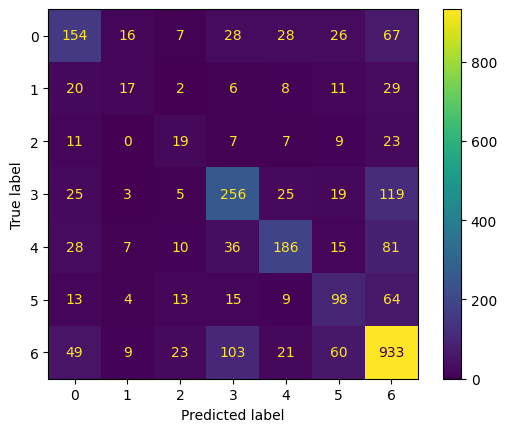

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay(confusion_matrix(all_labels, all_preds)).plot()
plt.show()

In [ ]:
print (classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.51      0.47      0.49       326
           1       0.30      0.18      0.23        93
           2       0.24      0.25      0.25        76
           3       0.57      0.57      0.57       452
           4       0.65      0.51      0.57       363
           5       0.41      0.45      0.43       216
           6       0.71      0.78      0.74      1198

    accuracy                           0.61      2724
   macro avg       0.49      0.46      0.47      2724
weighted avg       0.60      0.61      0.60      2724



In [ ]:
def decode_output(batch_conv, batch_start, batch_end, thres=None):
    output = {}
    sep_token = tokenizer.vocab['[SEP]']
    start_indices = np.where(batch_start > 0.0115)
    end_indices = np.where(batch_end > 0.008)
    for i in range(len(batch_conv['input_ids'])):
        conv = batch_conv['input_ids'][i]
        output[i] = []
        if i in start_indices[0]:
            s_idx = start_indices[1][np.where(start_indices[0] == i)]
            e_idx = end_indices[1][np.where(end_indices[0] == i)]

            utt_ids = [len([x for x in conv[:k] if x == sep_token]) for k in s_idx]
            #print(utt_ids)
            texts = [tokenizer.decode(conv[s_idx[j]:e_idx[j]+1]) for j in range(len(s_idx))]

            output[i] = [str(utt_ids[k])+'_'+texts[k] for k in range(len(texts))]
    return output



In [ ]:
decode_output(val_batch_conv[0], all_starts[0], all_ends[0])

IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
for i in range(len(val_batch_conv)):
    (all_starts[i] > 0.3)
    all_ends[i] > 0.3

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 356 and the array at index 1 has size 458

In [ ]:
np.where(all_starts[0] > 0.0115)

(array([ 3,  3, 13, 13, 13, 13, 13, 13]),
 array([10, 23,  3,  4,  5,  6,  7,  9]))

In [ ]:
np.where(all_ends[0] > 0.008)

(array([ 3,  3,  3, 13, 13, 13, 13, 13]),
 array([ 7, 16, 56, 11, 38, 39, 40, 46]))

In [ ]:
tokenizer.decode(val_batch_conv[0]['input_ids'][3][10:16])

'it is clearly an emma'

In [ ]:
torch.where(val_batch_start[0][2] > 0)

(tensor([178]),)

In [ ]:
all_starts[0][2]>0.00468

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
all_starts[0].max()

0.013609205

In [ ]:
all_ends[0].max()

0.009102889

In [ ]:
a = [i for i in val_batch_conv[0]['input_ids'][np.where(all_starts[0] > 0.035)[0]]]

In [ ]:
# a

In [ ]:
[tokenizer.decode(a[i][np.where(all_starts[0] > 0.035)[1][i]]) for i in range(len(a))]

['.', '?', '!', '.', '?', '?', 'like', '?', '.']

In [ ]:
val_batch_conv[0]['input_ids'][8,131]

tensor(119, device='cuda:0')

In [ ]:
model = NLIClassifier(output_size=len(possible_labels), hidden_size=32)
model.bert.resize_token_embeddings(len(tokenizer))
model.to(device)
out, outs, oute = model(batch_encoded_conversation[0].to(device))

NameError: name 'possible_labels' is not defined

In [ ]:
out, outs, oute = predict(model, val_batch_conv[3].to(device))

In [ ]:
np.concatenate([outs.reshape(-1), outs.reshape(-1)]).shape

(7552,)

In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("Nakul24/Spanbert-emotion-extraction")
model = AutoModelForQuestionAnswering.from_pretrained("Nakul24/Spanbert-emotion-extraction")

In [ ]:
inp = tokenizer(target_utt_list[:2], context_list[:2], padding=True, return_tensors='pt')

In [ ]:
out = model(**inp)

In [ ]:
torch.argmax(out.start_logits, axis=1), torch.argmax(out.end_logits, axis=1)

(tensor([94, 41]), tensor([30, 44]))

In [ ]:
tokenizer.decode(inp['input_ids'][1, 41:45])

'naked. [SEP] ['